In [1]:
def lstm_rsfmri(mask):
    # 작업에 필요한 라이브러리 적용
    import nibabel as nib 
    from glob import glob
    import numpy as np
    import warnings
    from sklearn.model_selection import train_test_split
    from keras.utils.np_utils import to_categorical  

    global before_treatment,healthy        #현재 함수 밖에서도 사용가능하게 변수를 전역함수로 설정
    global X_train, X_test, Y_train, Y_test,all_treatment, all_label   #현재 함수 밖에서도 사용가능하게 변수를 전역함수로 설정

    print('현재 작업중인 MASK: ', mask)
    print('---------------------------')
#####
    before_data = glob("//Users//hyejin//Desktop//task//before_treatment2//*") # 치료전 환자의 40명 데이터 불러와서 before_data변수에 저장
    healthy_data = glob("//Users//hyejin//Desktop//task//normal//*") #정상인 40명 데이터 불러와서 healthy_data변수에 저장
#####    
    print('치료 전 데이터 수: ', len(before_data))
    print('정상인 데이터 수: ', len(healthy_data))
    print('------------------')

    mask = nib.load('//Users//hyejin//Desktop//task//power_roi//{}'.format(mask) ) #마스크 데이터 불러와서 mask변수에 저장
    mask = mask.get_fdata() # 마스크 데이터의 fdata값만 불러와서 mask변수에 다시 저장
    mask_reshape = mask.reshape(mask.shape[0] * mask.shape[1] * mask.shape[2]) #마스크 데이터의 값을 3차원에서 1차원으로 shape변경(1값만 가져오기 위함)
    mask_reshape = np.array(mask_reshape) #shape변경한걸 numpy배열형태로 변경
    mask_reshape = mask_reshape.tolist() #numpy배열을 다시 list형태로 변경
    mask_index = [i for i, value in enumerate(mask_reshape) if value == 1.0] #마스크 데이터의 값 중에서 1의 index만 찾아서 list형태로 저장
    print('mask_index_length: ', len(mask_index))
    print('---------------------------')

    before_treatment = list() #치료전 환자의 fdata를 담을 변수 생성
    healthy = list() #정상인 환자의 fdata를 담을 변수 생성

    for nii in before_data: #for문을 사용하여 40명의 치료전 환자 각각의 fdata 추출
        nii = nib.load(nii)
        nii = nii.get_fdata()
        nii = nii.tolist() #추출한 fdata를 list형태로 변경
        before_treatment.append(nii) #형태 변경후 before_treatment변수에 저장 
    
    for nii in healthy_data: #for문을 사용하여 40명의 정상인 각각의 fdata 추출
        nii = nib.load(nii)
        nii = nii.get_fdata()
        nii = nii.tolist() #추출한 fdata를 list형태로 변경
        healthy.append(nii) #형태 변경후 healthy변수에 저장 

    before_treatment = np.array(before_treatment) #before_treatment 변수를 numpy배열로 변경
    healthy = np.array(healthy) #healthy 변수를 numpy배열로 변경
    
    before_treatment_reshape = before_treatment.reshape(len(before_data), 151552, 115) #before_treatment데이터의 shape(64, 64, 37, 115)을 40, 151552(64*64*37), 115로 변경
    healthy_reshape = healthy.reshape(len(healthy_data), 151552, 115) #healthy데이터의 shape(64, 64, 37, 115)을 40, 151552(64*64*37), 115로 변경
    
    before_treatment_reshape2 = np.swapaxes(before_treatment_reshape, 0, 2) #before_treatment의 3차원축과 1차원 축을 바꿈(마스크를 위함)
    healthy_reshape2 = np.swapaxes(healthy_reshape, 0, 2) #healthy 3차원축과 1차원 축을 바꿈(마스크를 위함)

    aaa = before_treatment_reshape2[:,mask_index,:] # before_treatment_reshape2 데이터에 마스크를 씌우고 aaa변수에 저장
    sw_aaa = np.swapaxes(aaa, 1, 2) #aaa변수의 2차원 축과 1차원 축을 서로 바꾸고 sw_aaa변수에 저장
    before_treatment = np.swapaxes(sw_aaa, 0, 1) # sw_aaa변수의 3차원 축과 2차원 축을 다시 바꿔서 원래 형태로 만든후 before_treatment변수에 다시 저장 
    print(np.shape(before_treatment))
    print('---------------------------')
    
    bbb = healthy_reshape2[:,mask_index,:] # healthy_reshape2 데이터에 마스크를 씌우고 bbb변수에 저장
    sw_bbb = np.swapaxes(bbb, 1, 2) #bbb변수의 2차원 축과 1차원 축을 서로 바꾸고 sw_bbb변수에 저장
    healthy = np.swapaxes(sw_bbb, 0, 1) # sw_bbb변수의 3차원 축과 2차원 축을 다시 바꿔서 원래 형태로 만든후 healthy변수에 다시 저장 
    print(np.shape(healthy))
    print('---------------------------')

    all_treatment = np.concatenate((before_treatment, healthy)) # before_treatment 데이터와 healthy데이터를 all_treatment변수에 합쳐서 저장
    print('치료전, 정상인 데이터 총 shape: ', all_treatment.shape)
    print('---------------------')

    before_label = [] # 치료전 데이터의 label을 저장할 before_label변수 생성
    healthy_label = [] # 정상인 데이터의 label을 저장할 healthy_label변수 생성
    for i in range(len(before_data)): # 치료전 환자의 수 만큼 label 0을 before_label변수에 저장(총 0이 40개 저장)
        before_label.append(0)
    for j in range(len(healthy_data)): # 정산인의 수 만큼 label 1을 healthy_label변수에 저장(총 1이 40개 저장)
        healthy_label.append(1)
    all_label = before_label + healthy_label # 치료전 환자의 label과 정상인의 label을 all_label변수에 모두 저장
    all_label = np.array(all_label) # all_label변수를 list형태에서 numpy형태로 저장
    print('총 label 수: ', len(all_label))

    X_train, X_test, Y_train, Y_test = train_test_split(all_treatment, all_label, random_state=42, test_size = 0.3) # 모든 준비가 끝난 all_treatment와 all_label을 모델에 사용하기 위한 작업
    # 학습데이터와 테스트데이터 7:3으로 나눔, random_state를 주어 나눌때 마다 랜덤으로 나누어짐


    Y_train = to_categorical(Y_train, 2).astype(int) # Y_train label 0과 1을 원핫인코딩
    Y_test = to_categorical(Y_test, 2).astype(int) # Y_test label 0과 1을 원핫인코딩

    print('X_train : ',X_train.shape,'X_test : ',X_test.shape)
    print('Y_train : ',Y_train.shape,'Y_test : ',Y_test.shape)
    print('------------------------------')




In [2]:
#부트스트랩을 하기 위한 작업들(hypothesis_testing)

def get_train_test(X, y, i, verbrose=False): #train 데이터와 test데이터를 나누는 함수 생성
  #필요한 library 적용
  import numpy as np 
  from keras import utils
  from sklearn.model_selection import train_test_split
  
  X_train, X_test, y_train, y_test = train_test_split(X,
                                        y, test_size=0.2, random_state=i) # train 데이터와 test데이터를 8:2로 나눔 


  t_shape=np.array(all_treatment).shape[1] #all_treatment의 shape에서 index 1번째 값 저장
  RSN_shape=np.array(all_treatment).shape[2] #all_treatment의 shape에서 index 2번째 값 저장
  
  X_train = np.reshape(X_train, (len(X_train), t_shape, RSN_shape)) #X_train을 모델에 적용하기 위해 shape변경(ex 30, 37, 115)
  X_test = np.reshape(X_test, (len(X_test), t_shape, RSN_shape)) #X_train을 모델에 적용하기 위해 shape변경(ex 30, 37, 115)

  # enforce continuous labeling
  X_train = X_train.astype('float32') #X_train 데이터를 실수로 변경
  X_test = X_test.astype('float32') #X_test 데이터를 실수로 변경
  
  # print if verbrose
  if verbrose:
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
  
  # Converts class vectors to binary class matrices.
  y_train = utils.to_categorical(y_train, 2) # Y_train label 0과 1을 원핫인코딩
  y_test = utils.to_categorical(y_test, 2) # Y_test label 0과 1을 원핫인코딩
  
  return X_train, X_test, y_train, y_test

In [7]:
lstm_rsfmri('12_resized.nii') #power_roi '12_resized.nii' 데이터를 불러와서 마스크 적용 후 train데이터와 test데이터로 분리.

현재 작업중인 MASK:  12_resized.nii
---------------------------
치료 전 데이터 수:  40
정상인 데이터 수:  40
------------------
mask_index_length:  63
---------------------------
(40, 115, 63)
---------------------------
(40, 115, 63)
---------------------------
치료전, 정상인 데이터 총 shape:  (80, 115, 63)
---------------------
총 label 수:  80
X_train :  (56, 115, 63) X_test :  (24, 115, 63)
Y_train :  (56, 2) Y_test :  (24, 2)
------------------------------


In [8]:
from keras.models import Sequential #순차모델을 위한 Sequential 라이브리러 적용
from keras.layers import Dense #Dense 라이브러리 적용
from keras.layers import LSTM #LSTM 라이브러리 적용
import numpy as np
from keras import models #models 라이브러리 적용

model = Sequential() #순차 모델 생성

model.add(LSTM(units=63, #첫 입력층 unit크기는 마스크 크기로 설정
               return_sequences=True, #시퀀스 출력여부는 True(LSTM레이어를 쌓아야하기 때문)
               input_shape=(115,63))) #입력크기는 mri이미지 크기, mask voxels크기

model.add(LSTM(units=31,  #두번째 은닉층의 unit크기는 반으로 줄임
               return_sequences=False)) #시퀀스 출력여부는 False(더이상 LSTM레이를 안쌓기 때문)

model.add(Dense(units=2, #마지막 FC계층은 치료전 환자, 정상인 분류를 위해 unit크기는 2로 설정
                activation="sigmoid")) #이진분류이므로 활성함수는 sigmoid로 설정

model.summary() #모델 통계를 보여줌

model.compile(loss='binary_crossentropy', #모델 적용을 위한 세팅으로 이진분류이므로 손실함수는 binary-crossentropy로 설정
                optimizer='Adam', #매개변수 최적화는 Adam으로 설정
                metrics=['binary_accuracy']) #모델이 학습할때 마다 binary_accuracy를 보여줌

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1) # 세팅된 모델에 train데이터와 test데이터를 넣어서 학습(총 학습횟수는 30)
                 

2022-10-17 23:11:22.838193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 115, 63)           32004     
                                                                 
 lstm_1 (LSTM)               (None, 31)                11780     
                                                                 
 dense (Dense)               (None, 2)                 64        
                                                                 
Total params: 43,848
Trainable params: 43,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 6s 945ms/step - loss: 0.6796 - binary_accuracy: 0.5446 - val_loss: 0.6989 - val_binary_accuracy: 0.6458
Epoch 2/30
2/2 [==============================] - 0s 85ms/step - loss: 0.6611 - binary_accuracy: 0.6786 - val_loss: 0.6890 - val_binary_accuracy: 0.6875
Epoch 3/3

In [9]:


def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  from sklearn.metrics import accuracy_score
  from sklearn.metrics import roc_curve

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test) #?
    y_test_1d=[i[0] for i in y_test] #?
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred] #?

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d) #?
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d) #?
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

64 train samples
16 test samples
fitting..
Epoch 1/50
2/2 [==============================] - 2s 48ms/step - loss: 0.4846 - binary_accuracy: 0.7812
Epoch 2/50
2/2 [==============================] - 0s 52ms/step - loss: 0.4827 - binary_accuracy: 0.7812
Epoch 3/50
2/2 [==============================] - 0s 43ms/step - loss: 0.4814 - binary_accuracy: 0.7812
Epoch 4/50
2/2 [==============================] - 0s 53ms/step - loss: 0.4797 - binary_accuracy: 0.7812
Epoch 5/50
2/2 [==============================] - 0s 52ms/step - loss: 0.4780 - binary_accuracy: 0.7812
Epoch 6/50
2/2 [==============================] - 0s 57ms/step - loss: 0.4773 - binary_accuracy: 0.7812
Epoch 7/50
2/2 [==============================] - 0s 59ms/step - loss: 0.4776 - binary_accuracy: 0.7812
Epoch 8/50
2/2 [==============================] - 0s 52ms/step - loss: 0.4759 - binary_accuracy: 0.7812
Epoch 9/50
2/2 [==============================] - 0s 47ms/step - loss: 0.4756 - binary_accuracy: 0.7812
Epoch 10/50
2/2 [====

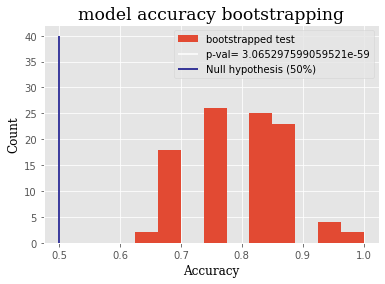

p-value:  3.065297599059521e-59


In [10]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):

  font = {'family': 'serif',
         'color': 'black',
         'weight': 'normal',
         'size': 'xx-large'
         }

  font2 = {'family': 'serif',
         'color': 'black',
         'weight': 'normal',
         }       
  '''
  plots the bootstrapping results with the null hypothesis value
  '''

  
  plt.hist(stats, label='bootstrapped test')
  plt.vlines(.5, 0, 40, color='white', label='p-val= {}'.format(p_val))
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('model accuracy bootstrapping', fontdict=font)
  plt.xlabel('Accuracy', fontdict=font2)
  plt.ylabel('Count', fontdict=font2)
  plt.legend()
  plt.plot()
  plt.show()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

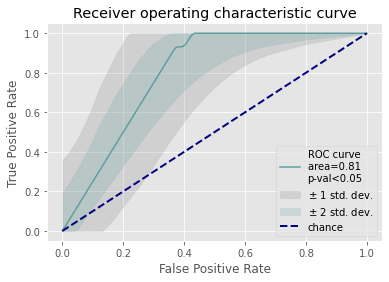

In [11]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [3]:
lstm_rsfmri('27_resized.nii')

현재 작업중인 MASK:  27_resized.nii
---------------------------
치료 전 데이터 수:  40
정상인 데이터 수:  40
------------------
mask_index_length:  28
---------------------------
(40, 115, 28)
---------------------------
(40, 115, 28)
---------------------------
치료전, 정상인 데이터 총 shape:  (80, 115, 28)
---------------------
총 label 수:  80
X_train :  (56, 115, 28) X_test :  (24, 115, 28)
Y_train :  (56, 2) Y_test :  (24, 2)
------------------------------


In [4]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=28,
               return_sequences=True, 
               input_shape=(115,28)))

model.add(LSTM(units=14,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

2022-10-18 00:12:14.863630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 115, 28)           6384      
                                                                 
 lstm_1 (LSTM)               (None, 14)                2408      
                                                                 
 dense (Dense)               (None, 2)                 30        
                                                                 
Total params: 8,822
Trainable params: 8,822
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 6s 1s/step - loss: 0.6830 - binary_accuracy: 0.4911 - val_loss: 0.6791 - val_binary_accuracy: 0.4375
Epoch 2/30
2/2 [==============================] - 0s 90ms/step - loss: 0.6786 - binary_accuracy: 0.5000 - val_loss: 0.6761 - val_binary_accuracy: 0.6042
Epoch 3/30
2/2

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

fitting..
Epoch 1/50
2/2 [==============================] - 2s 43ms/step - loss: 0.6069 - binary_accuracy: 0.6875
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 0.6037 - binary_accuracy: 0.6875
Epoch 3/50
2/2 [==============================] - 0s 36ms/step - loss: 0.6004 - binary_accuracy: 0.6875
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 0.5962 - binary_accuracy: 0.6875
Epoch 5/50
2/2 [==============================] - 0s 39ms/step - loss: 0.5940 - binary_accuracy: 0.6875
Epoch 6/50
2/2 [==============================] - 0s 45ms/step - loss: 0.5890 - binary_accuracy: 0.6875
Epoch 7/50
2/2 [==============================] - 0s 48ms/step - loss: 0.5869 - binary_accuracy: 0.6875
Epoch 8/50
2/2 [==============================] - 0s 43ms/step - loss: 0.5864 - binary_accuracy: 0.6875
Epoch 9/50
2/2 [==============================] - 0s 38ms/step - loss: 0.5850 - binary_accuracy: 0.6875
Epoch 10/50
2/2 [==============================] - 0s 

p-value:  1.76178364948044e-32


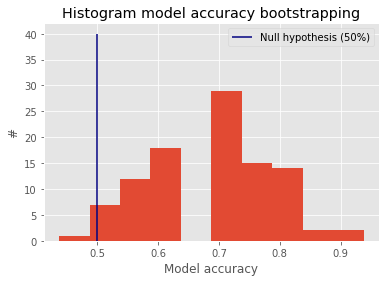

In [6]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

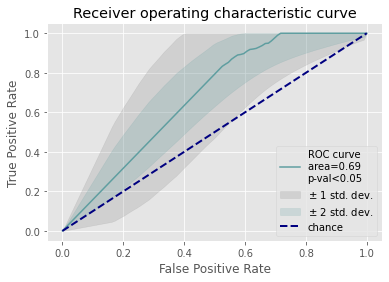

In [8]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [3]:
lstm_rsfmri('36_resized.nii')

현재 작업중인 MASK:  36_resized.nii
---------------------------
치료 전 데이터 수:  40
정상인 데이터 수:  40
------------------
mask_index_length:  50
---------------------------
(40, 115, 50)
---------------------------
(40, 115, 50)
---------------------------
치료전, 정상인 데이터 총 shape:  (80, 115, 50)
---------------------
총 label 수:  80
X_train :  (56, 115, 50) X_test :  (24, 115, 50)
Y_train :  (56, 2) Y_test :  (24, 2)
------------------------------


In [4]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=50,
               return_sequences=True, 
               input_shape=(115,50)))

model.add(LSTM(units=25,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

2022-10-18 09:39:46.660743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 115, 50)           20200     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 2)                 52        
                                                                 
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 4s 820ms/step - loss: 0.7011 - binary_accuracy: 0.4821 - val_loss: 0.6894 - val_binary_accuracy: 0.5833
Epoch 2/30
2/2 [==============================] - 0s 75ms/step - loss: 0.6789 - binary_accuracy: 0.5268 - val_loss: 0.6756 - val_binary_accuracy: 0.6250
Epoch 3/3

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

fitting..
Epoch 1/50
2/2 [==============================] - 2s 35ms/step - loss: 0.4947 - binary_accuracy: 0.7969
Epoch 2/50
2/2 [==============================] - 0s 36ms/step - loss: 0.4704 - binary_accuracy: 0.8203
Epoch 3/50
2/2 [==============================] - 0s 36ms/step - loss: 0.4470 - binary_accuracy: 0.8359
Epoch 4/50
2/2 [==============================] - 0s 37ms/step - loss: 0.5034 - binary_accuracy: 0.7656
Epoch 5/50
2/2 [==============================] - 0s 34ms/step - loss: 0.4778 - binary_accuracy: 0.7969
Epoch 6/50
2/2 [==============================] - 0s 37ms/step - loss: 0.4601 - binary_accuracy: 0.8125
Epoch 7/50
2/2 [==============================] - 0s 39ms/step - loss: 0.4545 - binary_accuracy: 0.8125
Epoch 8/50
2/2 [==============================] - 0s 38ms/step - loss: 0.4342 - binary_accuracy: 0.8281
Epoch 9/50
2/2 [==============================] - 0s 35ms/step - loss: 0.4528 - binary_accuracy: 0.8125
Epoch 10/50
2/2 [==============================] - 0s 

p-value:  1.3805389853512266e-48


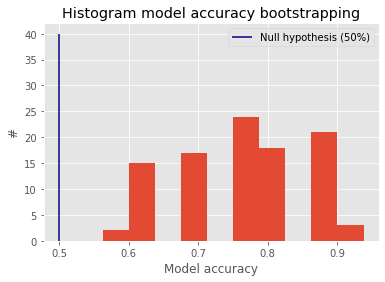

In [6]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

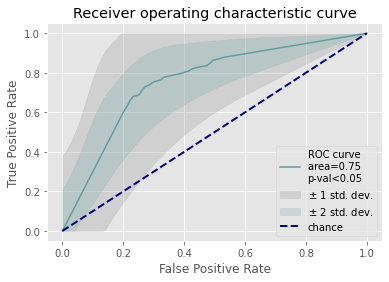

In [7]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [3]:
lstm_rsfmri('43_resized.nii')

현재 작업중인 MASK:  43_resized.nii
---------------------------
치료 전 데이터 수:  40
정상인 데이터 수:  40
------------------
mask_index_length:  50
---------------------------
(40, 115, 50)
---------------------------
(40, 115, 50)
---------------------------
치료전, 정상인 데이터 총 shape:  (80, 115, 50)
---------------------
총 label 수:  80
X_train :  (56, 115, 50) X_test :  (24, 115, 50)
Y_train :  (56, 2) Y_test :  (24, 2)
------------------------------


In [4]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=50,
               return_sequences=True, 
               input_shape=(115,50)))

model.add(LSTM(units=25,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

2022-10-18 14:38:21.602307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 115, 50)           20200     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 2)                 52        
                                                                 
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 6s 859ms/step - loss: 0.7081 - binary_accuracy: 0.5446 - val_loss: 0.6883 - val_binary_accuracy: 0.5417
Epoch 2/30
2/2 [==============================] - 0s 79ms/step - loss: 0.6764 - binary_accuracy: 0.5357 - val_loss: 0.6795 - val_binary_accuracy: 0.5208
Epoch 3/3

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

fitting..
Epoch 1/50
2/2 [==============================] - 2s 37ms/step - loss: 0.5672 - binary_accuracy: 0.6875
Epoch 2/50
2/2 [==============================] - 0s 37ms/step - loss: 0.5555 - binary_accuracy: 0.6875
Epoch 3/50
2/2 [==============================] - 0s 38ms/step - loss: 0.5432 - binary_accuracy: 0.6875
Epoch 4/50
2/2 [==============================] - 0s 34ms/step - loss: 0.5357 - binary_accuracy: 0.6953
Epoch 5/50
2/2 [==============================] - 0s 40ms/step - loss: 0.5102 - binary_accuracy: 0.7109
Epoch 6/50
2/2 [==============================] - 0s 40ms/step - loss: 0.4933 - binary_accuracy: 0.7188
Epoch 7/50
2/2 [==============================] - 0s 38ms/step - loss: 0.4916 - binary_accuracy: 0.7344
Epoch 8/50
2/2 [==============================] - 0s 38ms/step - loss: 0.4945 - binary_accuracy: 0.7344
Epoch 9/50
2/2 [==============================] - 0s 38ms/step - loss: 0.4905 - binary_accuracy: 0.7344
Epoch 10/50
2/2 [==============================] - 0s 

p-value:  8.576864109537681e-49


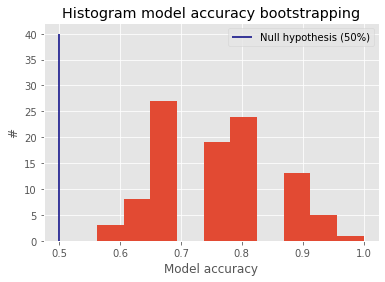

In [6]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

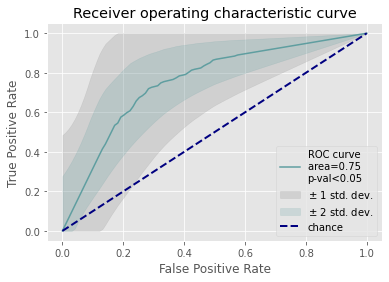

In [7]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [3]:
lstm_rsfmri('68_resized.nii')

현재 작업중인 MASK:  68_resized.nii
---------------------------
치료 전 데이터 수:  40
정상인 데이터 수:  40
------------------
mask_index_length:  71
---------------------------
(40, 115, 71)
---------------------------
(40, 115, 71)
---------------------------
치료전, 정상인 데이터 총 shape:  (80, 115, 71)
---------------------
총 label 수:  80
X_train :  (56, 115, 71) X_test :  (24, 115, 71)
Y_train :  (56, 2) Y_test :  (24, 2)
------------------------------


In [4]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=71,
               return_sequences=True, 
               input_shape=(115,71)))

model.add(LSTM(units=35,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

2022-10-18 15:55:31.261495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 115, 71)           40612     
                                                                 
 lstm_1 (LSTM)               (None, 35)                14980     
                                                                 
 dense (Dense)               (None, 2)                 72        
                                                                 
Total params: 55,664
Trainable params: 55,664
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 4s 814ms/step - loss: 0.6955 - binary_accuracy: 0.4643 - val_loss: 0.6788 - val_binary_accuracy: 0.5208
Epoch 2/30
2/2 [==============================] - 0s 74ms/step - loss: 0.6710 - binary_accuracy: 0.5804 - val_loss: 0.6762 - val_binary_accuracy: 0.6042
Epoch 3/3

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

fitting..
Epoch 1/50
2/2 [==============================] - 2s 43ms/step - loss: 0.6107 - binary_accuracy: 0.6875
Epoch 2/50
2/2 [==============================] - 0s 44ms/step - loss: 0.6071 - binary_accuracy: 0.6875
Epoch 3/50
2/2 [==============================] - 0s 44ms/step - loss: 0.6041 - binary_accuracy: 0.6875
Epoch 4/50
2/2 [==============================] - 0s 47ms/step - loss: 0.5920 - binary_accuracy: 0.6875
Epoch 5/50
2/2 [==============================] - 0s 52ms/step - loss: 0.5827 - binary_accuracy: 0.6875
Epoch 6/50
2/2 [==============================] - 0s 48ms/step - loss: 0.5787 - binary_accuracy: 0.6875
Epoch 7/50
2/2 [==============================] - 0s 49ms/step - loss: 0.5685 - binary_accuracy: 0.6875
Epoch 8/50
2/2 [==============================] - 0s 48ms/step - loss: 0.5657 - binary_accuracy: 0.6875
Epoch 9/50
2/2 [==============================] - 0s 49ms/step - loss: 0.5606 - binary_accuracy: 0.6875
Epoch 10/50
2/2 [==============================] - 0s 

p-value:  5.2489026064806986e-27


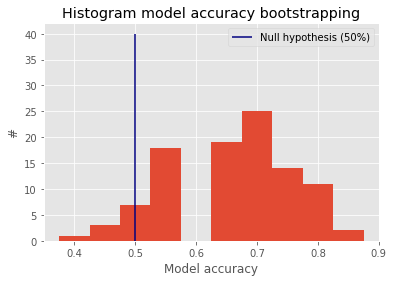

In [6]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

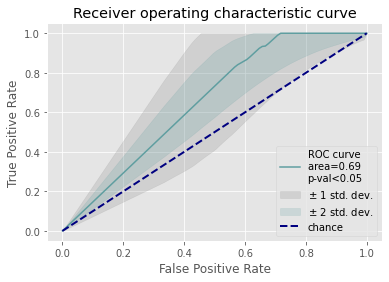

In [7]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [3]:
lstm_rsfmri('70_resized.nii')

현재 작업중인 MASK:  70_resized.nii
---------------------------
치료 전 데이터 수:  40
정상인 데이터 수:  40
------------------
mask_index_length:  67
---------------------------
(40, 115, 67)
---------------------------
(40, 115, 67)
---------------------------
치료전, 정상인 데이터 총 shape:  (80, 115, 67)
---------------------
총 label 수:  80
X_train :  (56, 115, 67) X_test :  (24, 115, 67)
Y_train :  (56, 2) Y_test :  (24, 2)
------------------------------


In [4]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=67,
               return_sequences=True, 
               input_shape=(115,67)))

model.add(LSTM(units=33,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

2022-10-18 17:01:07.735912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 115, 67)           36180     
                                                                 
 lstm_1 (LSTM)               (None, 33)                13332     
                                                                 
 dense (Dense)               (None, 2)                 68        
                                                                 
Total params: 49,580
Trainable params: 49,580
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 4s 803ms/step - loss: 0.7150 - binary_accuracy: 0.5268 - val_loss: 0.6861 - val_binary_accuracy: 0.5625
Epoch 2/30
2/2 [==============================] - 0s 75ms/step - loss: 0.7001 - binary_accuracy: 0.5714 - val_loss: 0.6799 - val_binary_accuracy: 0.5417
Epoch 3/3

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

fitting..
Epoch 1/50
2/2 [==============================] - 2s 45ms/step - loss: 0.6404 - binary_accuracy: 0.6562
Epoch 2/50
2/2 [==============================] - 0s 41ms/step - loss: 0.6358 - binary_accuracy: 0.6406
Epoch 3/50
2/2 [==============================] - 0s 41ms/step - loss: 0.6350 - binary_accuracy: 0.6328
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 0.6337 - binary_accuracy: 0.6406
Epoch 5/50
2/2 [==============================] - 0s 41ms/step - loss: 0.6289 - binary_accuracy: 0.6406
Epoch 6/50
2/2 [==============================] - 0s 40ms/step - loss: 0.6277 - binary_accuracy: 0.6406
Epoch 7/50
2/2 [==============================] - 0s 41ms/step - loss: 0.6223 - binary_accuracy: 0.6484
Epoch 8/50
2/2 [==============================] - 0s 42ms/step - loss: 0.6193 - binary_accuracy: 0.6484
Epoch 9/50
2/2 [==============================] - 0s 43ms/step - loss: 0.6154 - binary_accuracy: 0.6562
Epoch 10/50
2/2 [==============================] - 0s 

p-value:  1.4654011016533476e-16


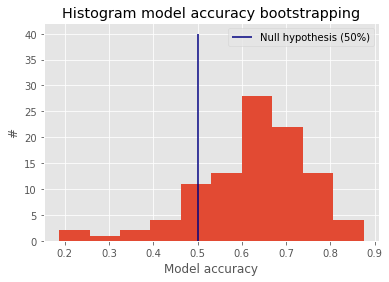

In [6]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

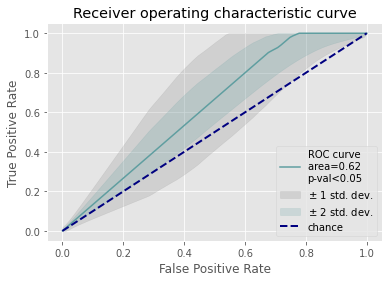

In [7]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [3]:
lstm_rsfmri('79_resized.nii')

현재 작업중인 MASK:  79_resized.nii
---------------------------
치료 전 데이터 수:  40
정상인 데이터 수:  40
------------------
mask_index_length:  55
---------------------------
(40, 115, 55)
---------------------------
(40, 115, 55)
---------------------------
치료전, 정상인 데이터 총 shape:  (80, 115, 55)
---------------------
총 label 수:  80
X_train :  (56, 115, 55) X_test :  (24, 115, 55)
Y_train :  (56, 2) Y_test :  (24, 2)
------------------------------


In [4]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=55,
               return_sequences=True, 
               input_shape=(115,55)))

model.add(LSTM(units=27,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

2022-10-18 17:54:31.449915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 115, 55)           24420     
                                                                 
 lstm_1 (LSTM)               (None, 27)                8964      
                                                                 
 dense (Dense)               (None, 2)                 56        
                                                                 
Total params: 33,440
Trainable params: 33,440
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 4s 786ms/step - loss: 0.7081 - binary_accuracy: 0.4911 - val_loss: 0.6922 - val_binary_accuracy: 0.6458
Epoch 2/30
2/2 [==============================] - 0s 73ms/step - loss: 0.6844 - binary_accuracy: 0.6696 - val_loss: 0.6812 - val_binary_accuracy: 0.7083
Epoch 3/3

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

fitting..
Epoch 1/50
2/2 [==============================] - 2s 35ms/step - loss: 0.5431 - binary_accuracy: 0.7656
Epoch 2/50
2/2 [==============================] - 0s 40ms/step - loss: 0.5230 - binary_accuracy: 0.7812
Epoch 3/50
2/2 [==============================] - 0s 36ms/step - loss: 0.5106 - binary_accuracy: 0.7969
Epoch 4/50
2/2 [==============================] - 0s 36ms/step - loss: 0.5013 - binary_accuracy: 0.7969
Epoch 5/50
2/2 [==============================] - 0s 38ms/step - loss: 0.4992 - binary_accuracy: 0.7969
Epoch 6/50
2/2 [==============================] - 0s 37ms/step - loss: 0.4964 - binary_accuracy: 0.7969
Epoch 7/50
2/2 [==============================] - 0s 36ms/step - loss: 0.4960 - binary_accuracy: 0.7969
Epoch 8/50
2/2 [==============================] - 0s 39ms/step - loss: 0.4931 - binary_accuracy: 0.7969
Epoch 9/50
2/2 [==============================] - 0s 38ms/step - loss: 0.4919 - binary_accuracy: 0.7969
Epoch 10/50
2/2 [==============================] - 0s 

p-value:  2.821615483563292e-66


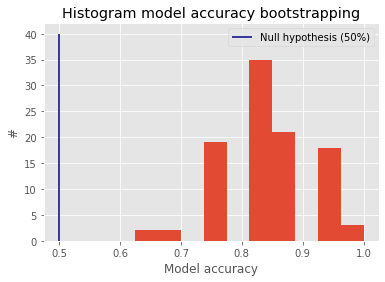

In [6]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

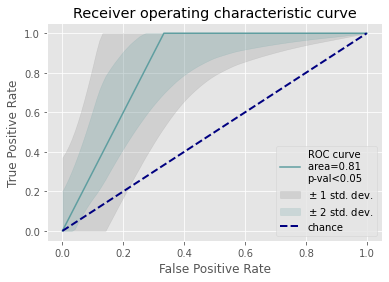

In [7]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('80_resized.nii')

현재 작업중인 MASK:  80_resized.nii
---------------------------
치료 전 데이터 수:  40
정상인 데이터 수:  40
------------------
mask_index_length:  52
---------------------------


In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=52,
               return_sequences=True, 
               input_shape=(115,52)))

model.add(LSTM(units=26,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('81_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=50,
               return_sequences=True, 
               input_shape=(115,50)))

model.add(LSTM(units=25,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('84_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=54,
               return_sequences=True, 
               input_shape=(115,54)))

model.add(LSTM(units=27,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('86_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=76,
               return_sequences=True, 
               input_shape=(115,76)))

model.add(LSTM(units=38,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('93_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=63,
               return_sequences=True, 
               input_shape=(115,63)))

model.add(LSTM(units=31,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('99_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=42,
               return_sequences=True, 
               input_shape=(115,42)))

model.add(LSTM(units=21,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('103_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=54,
               return_sequences=True, 
               input_shape=(115,54)))

model.add(LSTM(units=27,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('113_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=70,
               return_sequences=True, 
               input_shape=(115,70)))

model.add(LSTM(units=35,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('162_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=54,
               return_sequences=True, 
               input_shape=(115,54)))

model.add(LSTM(units=27,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('198_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=74,
               return_sequences=True, 
               input_shape=(115,74)))

model.add(LSTM(units=37,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('202_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=70,
               return_sequences=True, 
               input_shape=(115,70)))

model.add(LSTM(units=35,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)

In [ ]:
lstm_rsfmri('203_resized.nii')

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import numpy as np
from keras import models

model = Sequential()

model.add(LSTM(units=64,
               return_sequences=True, 
               input_shape=(115,64)))

model.add(LSTM(units=32,  
               return_sequences=False))

model.add(Dense(units=2, 
                activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                         epochs=30, verbose=1)
                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_treatment,
                                              all_label, i=i, verbrose=True)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr   
accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr = boostrapping_hypothesis_testing(X_train, Y_train, X_test, Y_test, n_iterations=100, n_epochs=50)  

In [ ]:
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def calc_p_val(stats, h0):
  '''
  finds the p value for the h0 under distribution provided 
  '''
  tset, pval = ttest_1samp(stats, h0)
  return pval

def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats,)
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')
  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()



p_val=calc_p_val(accuracy, .5)
plot_p_value(accuracy, p_val)
crab_ttest = ttest_1samp(accuracy, 0.5)
print('p-value: ' , crab_ttest[1])

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)